[*********************100%***********************]  503 of 503 completed

5 Failed downloads:
['AMTM', 'GEV', 'SOLV', 'VLTO', 'SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')
[*********************100%***********************]  155 of 155 completed


Error processing date 2018-12-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing date 2019-01-01: at least one of the assets must have an expected return exceeding the risk-free rate
Error processing date 2020-04-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing date 2021-02-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing date 2022-06-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing date 2022-12-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')
Error processing date 2023-04-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible')


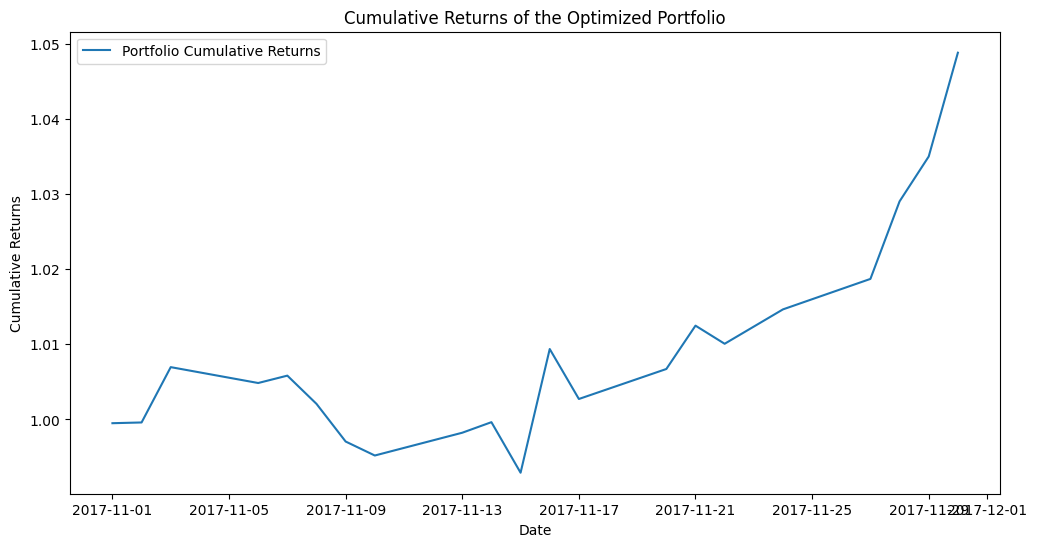

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

warnings.filterwarnings('ignore')

# Step 1: Download S&P 500 Symbols
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

# Step 2: Define Dates
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)

# Step 3: Download Stock Data
df = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

# Step 4: Calculate Technical Indicators
# Garman-Klass Volatility
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2) / 2 - (2 * np.log(2) - 1) * ((np.log(df['adj close']) - np.log(df['open']))**2)

# RSI
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

# Bollinger Bands
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 1])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:, 2])

# ATR
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'], low=stock_data['low'], close=stock_data['close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())
df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# MACD
def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:, 0]
    return macd.sub(macd.mean()).div(macd.std())
df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# Dollar Volume
df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

# Step 5: Aggregate to Monthly Level and Filter Top 150 Most Liquid Stocks
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'high', 'low', 'close']]
data = (pd.concat([
    df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
    df.unstack()[last_cols].resample('M').last().stack('ticker')
], axis=1)).dropna()

data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank'] < 150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

# Step 6: Calculate Monthly Returns
def calculate_returns(df):
    outlier_cutoff = 0.005
    lags = [1, 2, 3, 6, 9, 12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                                .pct_change(lag)
                                .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                       upper=x.quantile(1-outlier_cutoff)))
                                .add(1)
                                .pow(1/lag)
                                .sub(1))
    return df
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

# Step 7: Download Fama-French Factors
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3', 'famafrench', start='2010')[0].drop('RF', axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
if isinstance(data.index, pd.MultiIndex):
    if data.index.levels[0].dtype == 'datetime64[ns, UTC]':
        data.index = data.index.set_levels(data.index.levels[0].tz_localize(None), level=0)
else:
    data.index = data.index.tz_localize(None)

# Join the data
factor_data = factor_data.join(data['return_1m']).sort_index()
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

# Step 8: Calculate Rolling Factor Betas
betas = (factor_data.groupby(level=1, group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

# Join the rolling factors data to the main features dataframe
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
data = data.join(betas.groupby('ticker').shift())
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.drop('adj close', axis=1)
data = data.dropna()

# Step 9: K-Means Clustering
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1, errors='ignore')

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4, random_state=0).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

# Step 10: Portfolio Selection
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 6] = target_rsi_values

# Filter for cluster 3 based on the hypothesis
filtered_df = data[data['cluster'] == 3].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

# Create a dictionary to hold stocks for each month
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

# Portfolio Optimization Function
def optimize_weights(prices, lower_bound=0):
    returns = expected_returns.mean_historical_return(prices=prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns, cov_matrix=cov, weight_bounds=(lower_bound, .1), solver='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()

# Step 11: Download Daily Prices for Portfolio Stocks
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df = yf.download(tickers=stocks, start=data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12), end=data.index.get_level_values('date').unique()[-1])

# Calculate Daily Returns
returns_dataframe = np.log(new_df['Adj Close']).diff()
portfolio_df = pd.DataFrame()

# Calculate Monthly Portfolio Weights and Returns
for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        daily_prices = new_df['Adj Close'].loc[optimization_start_date:optimization_end_date][cols]
        weights = optimize_weights(daily_prices)
        daily_returns = returns_dataframe[cols].loc[start_date:end_date]
        portfolio_return = (daily_returns * pd.Series(weights)).sum(axis=1)
        portfolio_df[start_date] = portfolio_return
    except Exception as e:
        print(f"Error processing date {start_date}: {e}")

# Step 12: Calculate Cumulative Returns
cumulative_returns = (1 + portfolio_df).cumprod()

# Plotting Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns.index, cumulative_returns.sum(axis=1), label='Portfolio Cumulative Returns')
plt.title('Cumulative Returns of the Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()
